# Inversion d'un système linéaire

Il existe de multiples approches numériques pour inverser un système linéaire. Nous allons ici nous limiter à des systèmes linéaires pour lesquels nous disposons d'autant d'équations que d'inconnues.

Au cours de la première séance de TP nous avons vu un exemple concret de système simple $2\times2$ pour lequel l'inversion pouvait conduire à des anomalies numériques selon la manière dont on aborde le système à résoudre.

Les problématiques numériques principales dans ce contexte sont
- le temps de calcul nécessaire pour la résolution du système
- la précision du résultat obtenu
- le conditionnement de la matrice

Si l'on essaie de résoudre numériquement un système de la forma $Ax=b$, une façon d'évaluer la précision du résultat obtenu est de calculer $\|Ax-b\|$ qui doit être nul (au sens numérique du terme, c'est-à-dire de l'ordre de la précision numérique) comparé à par exemple $\|b\|$.

Comme dans de nombreux problèmes numériques on a deux grandes classes d'approches :
- les approches génériques, qui s'appliquent dans une grande variété de situations, mais parfois avec un risque de sous-optimalité (aussi bien au niveau temps de calcul qu'au niveau précision)
- les approches spécifiques, qui s'appliquent uniquement à certains cas particuliers, et pour lesquels on va explicitement exploiter une propriété précise afin de diminuer le temps de calcul, améliorer la précision, ou les deux.

Ainsi par exemple la méthode du pivot de Gauss ne suppose pas de propriétés particulières pour la matrice et peut être rangée dans la classe des approches génériques ; cette méthode est en contrepartie souvent coûteuse en temps de calcul (typiquement $N^3$ par rapport à la taille $N$ de la matrice).

A contrario il existe des méthodes spécifiques pour les matrices symétriques, les matrices de Van der Monde, ...

## Algorithme générique - temps de calcul

Nous allons dans un premier temps nous intéresser à l'algorithme générique mis en oeuvre par la méthode numpy.linalg.inv. Pour cela vous devez écrire un programme python pour
- générer une matrice $A$ de dimension $N\times N$ et un vecteur second membre $b$ de dimension $N$ aléatoires
- inverser la matrice pour obtenir $A^{-1}$
- calculer $x=A^{-1}b$
- évaluer $Ax-b$ et $\|Ax-b\|$
en fonction de $N$. 

On veillera en particulier à évaluer le temps de calcul nécessaire pour l'inversion proprement dite et à tracer cette évolution du temps de calcul.

Montrer que cette évolution est en puissance de $N$, donc de la forme $N^\alpha$, et calculer $\alpha$ par régression linéaire sur les données obtenues. Superposer graphiquement les données réelles et les valeurs issues de la régression linéaire.

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import time as time

In [102]:
def mat(N):
    A = np.random.randn(N,N)
    b = np.random.randn(N,1)
    return(A,b)

In [118]:
N = [k for k in range(1,1000)]
EN = []
time_list = []
for n in N:
    A,b = mat(n)
    ta = time.time()
    A_inv = np.linalg.inv(A)
    tb = time.time()
    delta_t = tb - ta
    time_list.append(delta_t)
    x = np.dot(A_inv,b)
    prod = np.dot(A,x)
    ecart = prod-b
    norm_ecart = np.linalg.norm((prod - b), ord=1)
    EN.append(norm_ecart)

In [119]:
log_norm = np.log(EN)
log_time = np.log(time_list)
log_N = np.log(N)

/var/folders/j4/lrr3kpyj595c6wm1tgl3x8cm0000gn/T/ipykernel_23559/448436123.py:1: RuntimeWarning: divide by zero encountered in log
  log_norm = np.log(EN)


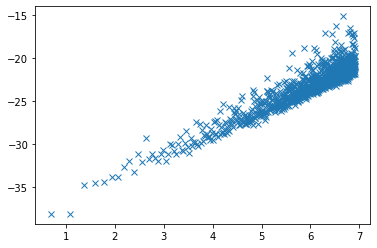

In [120]:
plt.plot(log_N,log_norm,'x')

[  2.14128053 -17.74689904]


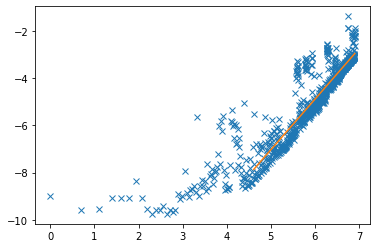

In [121]:
plt.plot(log_N,log_time,'x')
reg = np.polyfit(log_N[100:],log_time[100:],1)
print(reg)
Y_reg = [reg[0]*n + reg[1] for n in log_N[100:]]
plt.plot(log_N[100:],Y_reg,'-')

### Petit aparté sur la régression linéaire - rappel

On suppose disposer d'un ensemble de $n$ points $(x_i,y_i)$, $1\leq i\leq n$ pour lesquels on prévoit une évolution "proche" d'une droite. on essaye donc de trouver une représentation de ce jeu de données sous une forme $y=ax+b$ et on cherche à calculer les meilleures valeurs possibles pour $a$ et $b$.

Pour cela on évalue de manière globale l'écart entre les valeurs réelles $(y_i)$ et les valeurs estimées par la régression $(ax_i+b)$. Dans la mesure où l'on n'a pas de raison de considérer différemment les écarts positifs et négatifs on construit la fonction d'écart sous la forme
$$E(a,b)=\sum_{i=1}^{n}(ax_i+b-y_i)^2$$

Minimiser cet écart revient à trouver $a$ et $b$ de sorte que
$$\frac{\partial E(a,b)}{\partial a}=0~~~~~\mathrm{et}~~~~~\frac{\partial E(a,b)}{\partial b}=0$$
On obtient ainsi un système de deux équations 
$$\left\{
\begin{array}{rlrll}
\displaystyle\left(\sum_{i=1}^nx_i\right)^2a & + & \displaystyle\left(\sum_{i=1}^nx_i\right)b & = & \displaystyle\sum_{i=1}^nx_iy_i \\
\displaystyle\left(\sum_{i=1}^nx_i\right)a & + & nb & = & \displaystyle\sum_{i=1}^ny_i \\
\end{array}
\right.$$

A partir de ce système on peut aisément calculer $a$
$$a=\frac{\displaystyle\left(\sum_{i=1}^nx_i\right)\left(\sum_{i=1}^ny_i\right)-n\left(\sum_{i=1}^nx_iy_i\right)}{\displaystyle\left(\sum_{i=1}^nx_i\right)^2-n\left(\sum_{i=1}^nx_i^2\right)}
$$
et ensuite en déduire $b$
$$b=\frac{\displaystyle\left(\sum_{i=1}^ny_i\right)-a\left(\sum_{i=1}^nx_i\right)}{n}
$$

## Inversion d'une matrice de Van der Monde

Nous allons dans un premier temps nous intéresser au comportement de l'algorithme générique précédent dans le cas particulier d'une matrice de Van der Monde générée avec des points de référence équi-répartis entre $-1$ et $+1$.
Le vecteur second membre peut lui rester à valeurs aléatoires.

Evaluer l'erreur de précision numérique dans la résolution du système $Ax=b$ en fonction de la taille de la matrice de Van der Monde $N$. Tracer cette erreur en fonction de $N$.


In [ ]:
import numpy as np

In [155]:
def vandermonde(N):
    num = np.linspace(-1,1,N+1)
    vander = np.zeros((N+1,N+1))
    for k in range(vander.shape[1]):
        for i in range(vander.shape[0]):
            vander[i,k] = num[i]**k
    b = np.random.randn(N+1,1)
    return(vander,b)

In [156]:
vandermonde(5)

(array([[ 1.000e+00, -1.000e+00,  1.000e+00, -1.000e+00,  1.000e+00,
         -1.000e+00],
        [ 1.000e+00, -6.000e-01,  3.600e-01, -2.160e-01,  1.296e-01,
         -7.776e-02],
        [ 1.000e+00, -2.000e-01,  4.000e-02, -8.000e-03,  1.600e-03,
         -3.200e-04],
        [ 1.000e+00,  2.000e-01,  4.000e-02,  8.000e-03,  1.600e-03,
          3.200e-04],
        [ 1.000e+00,  6.000e-01,  3.600e-01,  2.160e-01,  1.296e-01,
          7.776e-02],
        [ 1.000e+00,  1.000e+00,  1.000e+00,  1.000e+00,  1.000e+00,
          1.000e+00]]),
 array([[ 1.0058997 ],
        [ 1.75892085],
        [-0.98893034],
        [ 1.69320666],
        [-0.2248568 ],
        [-1.07535826]]))

In [207]:
N = [k for k in range(1,50)]
EN = []
ENbis = []
for n in N:
    A,b = vandermonde(n)
    A_inv = np.linalg.inv(A)
    x = np.dot(A_inv,b)
    prod = np.dot(A_inv,x)
    ecart = prod-b
    norm_ecart = np.linalg.norm((prod - b), ord=1)
    EN.append(norm_ecart)    
    Pj = (0,1)
    num = np.linspace(-1,1,N+1)
    for j in range(len(num)):
        for n in range(num):
            if j != n:
                Pj *= np.poly1d([1/(num[j]-num[n]),(-num[n])/(num[j]-num[n])])
    coeff = Pj.c
    #x_bis = np.dot(coeff,b)
    #prod_bis = np.dot(coeff,x)
    #ecart_bis = prod_bis-b
    #norm_ecart_bis = np.linalg.norm((prod_bis - b), ord=1)
    #EN.append(norm_ecart)
    #EN_bis.append(norm_ecart_bis)
#log_N = np.log(N)
#log_norm = np.log(EN)
#log_norm_bis = np.log(EN_bis)
#plt.plot(log_N,log_norm)
#plt.plot(log_N,log_norm_bis)


TypeError: can only concatenate list (not "int") to list

In [206]:
coeff

array([inf, nan, nan, ..., nan, nan, inf])

## Inversion d'une matrice de Van der Monde par les polynômes de Lagrange

Considérant $N+1$ points de références $x_i$, $0\leq i\leq N$, deux à deux distincts, on considère le système de Van der Monde suivant
$$\left(
\begin{array}{cccc}
1 & 1 & \cdots & 1 \\
x_0 & x_1 & \cdots & x_N \\
x_0^2 & x_1^2 & \cdots & x_N^2 \\
\vdots & \vdots & \ddots & \vdots \\
x_0^N & x_1^N & \cdots & x_N^N \\
\end{array}
\right)\times
\left(\begin{array}{c}
w_0 \\
w_1 \\
w_2 \\
\vdots \\
w_N \\
\end{array}
\right)=
\left(\begin{array}{c}
q_0 \\
q_1 \\
q_2 \\
\vdots \\
q_N \\
\end{array}
\right)
$$

A partir des $N+1$ points de références on peut définir les polynômes de Lagrange de degré $N$
$$P_j(x)=\prod_{n=0,n\neq j}^N\frac{x-x_n}{x_j-x_n}=\sum_{k=0}^{N}A_{jk}x^k
$$
avec la propriété $P_j(x_i)=\delta_{ij}$, $\forall i,j\in[0,N]$.

On peut alors démontrer que les coefficients $A_{jk}$ des polynômes de Lagrange sont exactement les coefficients de la matrice de Van der Monde inverse, et que la solution du système initial est donnée par
$$w_j=\sum_{k=0}^{N}A_{jk}q_k
$$

La résolution du système initial passe donc par le calcul des polynômes de Lagrange et ne requiert pas le calcul de l'inverse de la matrice de Van der Monde initiale.

Il vous est ici demandé d'écrire un programme permettant
- de générer la matrice à partir de $N+1$ points de références équirépartis entre $-1$ et $+1$
- de générer un vecteur second membre aléatoire à valeurs entre $-1$ et $+1$
- de calculer la famille des polynômes de Lagrange
- de calculer la solution du système d'équations initial

On regardera en particulier le temps de calcul et la précision dans la résoluton, en comparaison avec les résultats obtenus précédemment.

## Méthodes itératives

Dans certaines situations il peut être intéressant d'utiliser des méthodes itératives car elles peuvent être significativement plus rapides en temps d'exécution, et éventuellement nécessiter beaucoup moins de mémoire de stockage.

Le principe des méthodes itératives consiste à remplacer de manière mathématiquement équivalente le système
$$A\cdot x=b$$
par une équation alternative de la forme
$$x=B\cdot x+c$$
où $B$ est une matrice inversible et $c$ un vecteur à déterminer afin d'assurer l'équivalence mathématique entre les deux formulations.

Le principe des méthodes itératives est classique et simple : on part d'une évaluation de la solution initiale $x_0$ et on itère la relation $x_{k+1}=B\cdot x_k+c$ jusqu'à obtenir convergence. On transforme donc le problème d'inversion de système linéaire en recherche de point fixe.

Le risque de ce genre de méthode est l'absence de convergence de l'itération ...

A partir de la norme des vecteur, on peut définir la norme d'une matrice par 
$$\|A\|=\max_{x\neq0}\frac{\|A\cdot x\|}{\|x\|}$$

On sait classiquement que cet opérateur présente toutes les caractéristiques d'une norme, avec une propriété complémentaire intéressante
$$\|AB\|\leq \|A\|\times\|B\|$$

### Théorème

Si $\|B\|<1$, alors
- le système $x=B\cdot x+c$ a une solution unique $x_s$
- l'itération $x_{k+1}=B\cdot x_k+c$ converge vers $x_s$ quel que soit le vecteur initial $x_0$

Pour ce qui est de la convergence : on suppose ici l'existence et l'unicité de la solution $x_s$. A titre de rappel la solution $x_s$ satisfait $x_s=B\cdot x_s+c$. On a alors
$$\begin{array}{ll}
x_{k+1}-x_s & = (B\cdot x_k+c)-(B\cdot x_s+c)=B\cdot(x_k-x_s) \\
& = B^2\cdot(x_{k-1}-x_s)=\cdots=B^{k+1}\cdot(x_0-x_s)
\end{array}$$

On a ainsi
$$
\|x_{k+1}-x_s\|=\|B^{k+1}\cdot(x_0-x_s)\|\leq\|B\|^{k+1}\|x_0-x_s\|
$$
et donc
$$\lim_{k\to+\infty}\|x_{k+1}-x_s\|=0$$
ce qui assure bien la convergence vers la solution $x_s$, et ce quel que soit le point de départ de l'itération $x_0$. Après la convergence sera d'autant plus rapide que la solution initiale $x_0$ est plus proche de la solution $x_s$ recherchée.

Pour ce qui est de l'existence et de l'unicité de la solution, elle est équivalente à l'inversibilité de la matrice $I-B$ ($I$ étant la matrice identité). Supposant cette matrice non inversible
$$\exists x_r\neq0\mathrm{~tel~que~}B\cdot x_r=x_r$$
ce qui est contradictoire avec l'hypothèse $\|B\|<1$.

### Mise en oeuvre pratique

Partant d'une matrice $K$ inversible choisie de manière pertinente, on peut facilement vérifier que le système $A\cdot x=b$ est équivalent à $x=B\cdot x+c$ avec 
$$B=I-K^{-1}A~~~~~/~~~~~c=K^{-1}b$$

D'un point de vue pratique on peut appliquer cette approche avec une matrice $A$ que l'on décompose sous la forme $A=L+D+U$ avec
- $L$ matrice triangulaire inférieure à diagonale nulle
- $U$ matrice triangulaire supérieure à diagonale nulle
- $D$ matrice diagonale

ce qui nous donne
$$L_{ij}=\left\{
\begin{array}{ll}
a_{ij} & \mathrm{si~} i>j \\
0 & \mathrm{si~} i\leq j \\
\end{array}
\right.
~~~~~~~~~~
U_{ij}=\left\{
\begin{array}{ll}
a_{ij} & \mathrm{si~} i<j \\
0 & \mathrm{si~} i\geq j \\
\end{array}
\right.
~~~~~~~~~~
D_{ij}=\delta_{ij}
$$

### La méthode de Jacobi

La méthode de Jacobi suppose que la matrice $D$ est à termes tous non nuls, ce qui permet d'assurer qu'elle est inversible et on choisit $K=D$. Ainsi l'itération peut s'écrire sous la forme
$$x_{k+1}=(I-D^{-1}A)\cdot x_k+D^{-1}\cdot b=-D^{-1}\cdot\left[(L+U)\cdot x_k-b\right]$$

On peut réécrire cette itération composante par composante
$$x_{i,k+1}=-\frac{1}{a_{ii}}\left(\sum_{j\neq i}a_{ij}x_{j,k}-b_i\right),~\forall i\in[1,n]$$

Remarque : $n$ est ici la taille de notre système linéaire.

### La méthode de Gauss-Seidel

De même que pour la méthode de Jacobi on suppose que la matrice $D$ est à termes tous non nuls et on choisit $K=L+D$. On obtient ainsi l'itération sous la forme

$$x_{k+1}=x_k-(L+D)^{-1}\cdot(A\cdot x_k-b)=-D^{-1}\cdot\left[L\cdot x_{k+1}+U\cdot x_k-b\right]$$

soit encore, composante par composante
$$x_{i,k+1}=-\frac{1}{a_{ii}}\left(\sum_{j<i}a_{ij}x_{j,k+1}+\sum_{j>i}a_{ij}x_{j,k}-b_i\right),~\forall i\in[1,n]$$

### Comparaison a priori des deux méthodes

Avant toute implémentation, on voit que la méthode de Jacobi part de l'itération $k$ pour évaluer l'itération suivante $k+1$. Dans le cas de la méthode de Gauss-Seidel, l'itération $k+1$ a besoin de l'itération précédente $k$, mais également de l'itération courante $k+1$.

Sous réserve de faire les calculs dans l'ordre adéquat, on ne risque pas de buter sur des valeurs non calculées, l'implémentation est donc parfaitement réalisable. Concrètement, il faut simplement calculer les composantes de $x_{k+1}$ dans l'ordre croissant de l'indice $i$.

On peut également en déduire que
- en cas de convergence des itérations, Gauss-Seidel devrait converger plus rapidement que Jacobi, puisque l'itération $k+1$ fait intervenir les itérations $k$ et $k+1$,
- en revanche en cas de divergence, Gauss-Seidel devrait diverger également plus rapidement que Jacobi

### Critères d'arrêt de l'itération

Comme pour toutes les méthodes itératives il est nécessaire de décider de critères d'arrêt. On a classiquement plusieurs solutions qui ne sont pas mutuellement exclusives :
- un nombre maximal d'itérations
- une détection de divergence : dans ce cas il est préférable de stopper l'itération au plus vite
- une détection de convergence : la convergence peut être identifiée par $\|x_{k+1}-x_k\|<\varepsilon\|x_k\|$.

### Implémentation pratique

On va mettre en oeuvre ces deux méthodes avec des matrices à coefficients aléatoires entre $-1$ et $+1$, en veillant simplement à assurer que les termes diagonaux des matrices ne sont pas nuls.

Le vecteur second membre peut également être choisi à valeurs aléatoires.

Implementer un code permettant de
- générer la matrice et le vecteur second membre
- itérer par les méthodes de Jacobi et Gauss-Seidel

avec le vecteur nul comme solution initiale de l'itération. Qu'observez-vous ?

Appliquer les mêmes itérations après translation de $+1$ de tous les termes diagonaux de la matrice. Refaire ensuite la même chose en translatant de $+2$, $+3$, ... Quelles remarques pouvez-vous faire concernant la convergence/divergence des itérations, et la vitesse de convergence/divergence ?

Comment peut-on interpréter cette opération de translation de la diagonale ?

En cas de convergence, on pourra également calculer l'erreur résiduelle $\|A\cdot x_s-b\|$.

In [176]:
def matrice(N):
    A = np.random.rand(N,N)
    A = A*2-1
    b = np.random.rand(N,1)
    b = b*2-1
    return(A,b)

(array([[ 0.38944612, -0.26083255,  0.29988914,  0.48790077,  0.88375069,
          0.35147679,  0.39642229, -0.6022933 ,  0.04296656,  0.26746424],
        [-0.94872911,  0.09739656,  0.9207587 , -0.77453811,  0.19243995,
         -0.85685139,  0.89309676, -0.96977836, -0.04530094,  0.97377415],
        [-0.6772043 , -0.78838782, -0.23750411, -0.17750971,  0.41483263,
         -0.38727238,  0.35682917, -0.06556138, -0.03359953, -0.39455959],
        [ 0.78689391,  0.00215681,  0.09631022,  0.93164212,  0.37717187,
          0.9490857 ,  0.7735862 , -0.79972075, -0.70208329, -0.97209874],
        [ 0.04789974,  0.51196791,  0.45201866,  0.88979279, -0.32090732,
         -0.12433788,  0.48937408,  0.54562254, -0.15105162, -0.9671525 ],
        [-0.56786996,  0.66503977,  0.78811728, -0.32738862,  0.70896657,
          0.01388023, -0.89192286,  0.90744578,  0.79929305,  0.27115862],
        [ 0.44635786, -0.70294961,  0.16797657,  0.33268794,  0.44010649,
          0.02027503, -0.3422949